<a href="https://colab.research.google.com/github/theravikumar/ViT_image_classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
%cd /content/drive/MyDrive/vit_implement/

/content/drive/MyDrive/vit_implement


In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION= 'gelu'
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS #16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 #49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        # Patching layer using 2D convolution followed by flattening
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )

        # Learnable parameter representing the [CLS] token
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)

        # Position embeddings for each patch
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Expand the [CLS] token to match the batch size
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        # Apply the patching layer and permute dimensions
        x = x.to(device)
        x = self.patcher(x).permute(0, 2, 1)

        # Concatenate the [CLS] token with the patch embeddings
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        # Apply dropout
        x = self.dropout(x)

        return x
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)  # (Batch_size, NUM_PATCHES+1, EMBED_DIM)

torch.Size([512, 50, 16])


In [9]:
class ViT(nn.Module):
  def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
    super().__init__()
    self.embedding_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
    encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
    self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embed_dim),
        nn.Linear(in_features=embed_dim, out_features=num_classes)
    )
  def forward(self, x):
    x = x.to(device)
    x = self.embedding_block(x)
    x = self.encoder_blocks(x)
    x = self.mlp_head(x[:,0,:])
    return x
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)

torch.Size([512, 10])


In [10]:
!pwd

/content/drive/MyDrive/vit_implement


In [11]:
train_df = pd.read_csv("/content/drive/MyDrive/vit_implement/digit-recognizer/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/vit_implement/digit-recognizer/test.csv")

In [12]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [15]:
class MNISTTrainDataset(Dataset):
  def __init__(self, images, labels, indicies):
    self.images = images
    self.labels = labels
    self.indicies = indicies
    self.transform = transforms.Compose([transforms.ToPILImage(),transforms.RandomRotation(15),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
  def __len__(self):
    return len(self.images)
  def __getitem__(self, idx):
    image = self.images[idx].reshape((28,28)).astype(np.uint8)
    label = self.labels[idx]
    index = self.indicies[idx]
    image = self.transform(image)

    return {"image":image, "label":label, "index":index}

class MNISTValDataset(Dataset):
  def __init__(self, images, labels, indicies):
    self.images = images
    self.labels = labels
    self.indicies = indicies
    self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
  def __len__(self):
    return len(self.images)
  def __getitem__(self, idx):
    image = self.images[idx].reshape((28,28)).astype(np.uint8)
    label = self.labels[idx]
    index = self.indicies[idx]
    image = self.transform(image)
    return {"image":image, "label":label, "index":index}

class MNISTTestDataset(Dataset):
  def __init__(self, images, indicies):
    self.images = images
    self.indicies = indicies
    self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
  def __len__(self):
    return len(self.images)
  def __getitem__(self, idx):
    image = self.images[idx].reshape((28,28)).astype(np.uint8)
    index = self.indicies[idx]
    image = self.transform(image)

    return {"image":image, "index":index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

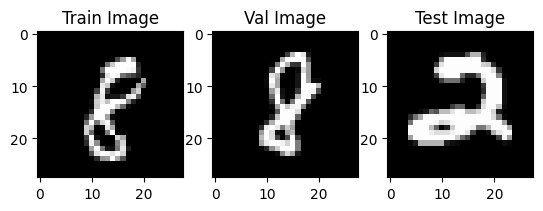

In [16]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:,0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap = "gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:,0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap = "gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTTestDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap = "gray")
axarr[2].set_title("Test Image")
print("-"*30)

In [17]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
  model.train()
  train_labels = []
  train_preds = []
  train_running_loss = 0
  for idx, img_label in enumerate(tqdm(train_dataloader, position=0,leave=True)):
    img = img_label["image"].float().to(device)
    label = img_label["label"].type(torch.uint8).to(device)
    y_pred = model(img)
    y_pred_label = torch.argmax(y_pred, dim=1)
    train_labels.extend(label.cpu().detach())
    train_preds.extend(y_pred_label.cpu().detach())
    loss = criterion(y_pred, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_running_loss += loss.item()
  train_loss = train_running_loss / (idx + 1)
  model.eval()
  val_labels = []
  val_preds = []
  val_running_loss = 0
  with torch.no_grad():
    for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
      img = img_label["image"].float().to(device)
      label = img_label["label"].type(torch.uint8).to(device)
      y_pred = model(img)
      y_pred_label = torch.argmax(y_pred, dim=1)
      val_labels.extend(label.cpu().detach())
      val_preds.extend(y_pred_label.cpu().detach())
      loss = criterion(y_pred, label)
      val_running_loss += loss.item()
  val_loss = val_running_loss / (idx + 1)

  print("-"*30)
  print(f"Train Loss EPOCH {epoch+1} : {train_loss:.4f}")
  print(f"Val Loss EPOCH {epoch+1} : {val_loss:.4f}")
  print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x==y) / len(train_labels):.4f}")
  print(f"Train Valid EPOCH {epoch+1}:{sum(1 for x,y in zip(val_preds, val_labels) if x==y) / len(val_labels):.4f}")
  print("-"*30)
  stop = timeit.default_timer()
  print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


------------------------------
Train Loss EPOCH 1 : 2.1563
Val Loss EPOCH 1 : 1.8722


  2%|▎         | 1/40 [00:22<14:41, 22.60s/it]

Train Accuracy EPOCH 1: 0.2102
Train Valid EPOCH 1:0.3407
------------------------------
Training Time: 22.61s


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


------------------------------
Train Loss EPOCH 2 : 1.7469
Val Loss EPOCH 2 : 1.5771


  5%|▌         | 2/40 [00:46<14:45, 23.32s/it]

Train Accuracy EPOCH 2: 0.4253
Train Valid EPOCH 2:0.5045
------------------------------
Training Time: 46.42s


100%|██████████| 9/9 [00:01<00:00,  7.48it/s]


------------------------------
Train Loss EPOCH 3 : 1.5026
Val Loss EPOCH 3 : 1.3466


  8%|▊         | 3/40 [01:15<16:07, 26.15s/it]

Train Accuracy EPOCH 3: 0.5406
Train Valid EPOCH 3:0.6260
------------------------------
Training Time: 75.94s


100%|██████████| 9/9 [00:00<00:00, 12.53it/s]


------------------------------
Train Loss EPOCH 4 : 1.3361
Val Loss EPOCH 4 : 1.1973


 10%|█         | 4/40 [01:46<16:37, 27.71s/it]

Train Accuracy EPOCH 4: 0.6206
Train Valid EPOCH 4:0.6760
------------------------------
Training Time: 106.04s


100%|██████████| 9/9 [00:00<00:00, 11.78it/s]


------------------------------
Train Loss EPOCH 5 : 1.2146
Val Loss EPOCH 5 : 1.0974


 12%|█▎        | 5/40 [02:11<15:44, 27.00s/it]

Train Accuracy EPOCH 5: 0.6710
Train Valid EPOCH 5:0.7176
------------------------------
Training Time: 131.77s


100%|██████████| 9/9 [00:00<00:00,  9.47it/s]


------------------------------
Train Loss EPOCH 6 : 1.1085
Val Loss EPOCH 6 : 0.9704


 15%|█▌        | 6/40 [02:37<15:05, 26.65s/it]

Train Accuracy EPOCH 6: 0.7138
Train Valid EPOCH 6:0.7795
------------------------------
Training Time: 157.74s


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


------------------------------
Train Loss EPOCH 7 : 1.0159
Val Loss EPOCH 7 : 0.8937


 18%|█▊        | 7/40 [03:00<14:01, 25.50s/it]

Train Accuracy EPOCH 7: 0.7522
Train Valid EPOCH 7:0.8133
------------------------------
Training Time: 180.88s


100%|██████████| 9/9 [00:00<00:00, 11.88it/s]


------------------------------
Train Loss EPOCH 8 : 0.9405
Val Loss EPOCH 8 : 0.8212


 20%|██        | 8/40 [03:26<13:36, 25.52s/it]

Train Accuracy EPOCH 8: 0.7776
Train Valid EPOCH 8:0.8262
------------------------------
Training Time: 206.44s


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


------------------------------
Train Loss EPOCH 9 : 0.8800
Val Loss EPOCH 9 : 0.7822


 22%|██▎       | 9/40 [03:52<13:15, 25.66s/it]

Train Accuracy EPOCH 9: 0.7924
Train Valid EPOCH 9:0.8324
------------------------------
Training Time: 232.40s


100%|██████████| 9/9 [00:00<00:00, 10.93it/s]


------------------------------
Train Loss EPOCH 10 : 0.8133
Val Loss EPOCH 10 : 0.6912


 25%|██▌       | 10/40 [04:17<12:44, 25.48s/it]

Train Accuracy EPOCH 10: 0.8097
Train Valid EPOCH 10:0.8526
------------------------------
Training Time: 257.47s


100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


------------------------------
Train Loss EPOCH 11 : 0.7512
Val Loss EPOCH 11 : 0.6766


 28%|██▊       | 11/40 [04:47<12:57, 26.81s/it]

Train Accuracy EPOCH 11: 0.8241
Train Valid EPOCH 11:0.8612
------------------------------
Training Time: 287.29s


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


------------------------------
Train Loss EPOCH 12 : 0.7165
Val Loss EPOCH 12 : 0.6080


 30%|███       | 12/40 [05:13<12:23, 26.54s/it]

Train Accuracy EPOCH 12: 0.8312
Train Valid EPOCH 12:0.8788
------------------------------
Training Time: 313.24s


100%|██████████| 9/9 [00:00<00:00,  9.50it/s]


------------------------------
Train Loss EPOCH 13 : 0.6737
Val Loss EPOCH 13 : 0.5861


 32%|███▎      | 13/40 [05:35<11:21, 25.25s/it]

Train Accuracy EPOCH 13: 0.8413
Train Valid EPOCH 13:0.8702
------------------------------
Training Time: 335.50s


100%|██████████| 9/9 [00:00<00:00, 11.72it/s]


------------------------------
Train Loss EPOCH 14 : 0.6305
Val Loss EPOCH 14 : 0.5435


 35%|███▌      | 14/40 [05:58<10:39, 24.61s/it]

Train Accuracy EPOCH 14: 0.8528
Train Valid EPOCH 14:0.8857
------------------------------
Training Time: 358.65s


100%|██████████| 9/9 [00:00<00:00,  9.06it/s]


------------------------------
Train Loss EPOCH 15 : 0.6015
Val Loss EPOCH 15 : 0.5026


 38%|███▊      | 15/40 [06:22<10:07, 24.29s/it]

Train Accuracy EPOCH 15: 0.8538
Train Valid EPOCH 15:0.8883
------------------------------
Training Time: 382.20s


100%|██████████| 9/9 [00:00<00:00, 12.39it/s]


------------------------------
Train Loss EPOCH 16 : 0.5682
Val Loss EPOCH 16 : 0.4718


 40%|████      | 16/40 [06:44<09:25, 23.58s/it]

Train Accuracy EPOCH 16: 0.8639
Train Valid EPOCH 16:0.8955
------------------------------
Training Time: 404.11s


100%|██████████| 9/9 [00:00<00:00,  9.32it/s]


------------------------------
Train Loss EPOCH 17 : 0.5474
Val Loss EPOCH 17 : 0.4869


 42%|████▎     | 17/40 [07:06<08:55, 23.30s/it]

Train Accuracy EPOCH 17: 0.8660
Train Valid EPOCH 17:0.8836
------------------------------
Training Time: 426.78s


100%|██████████| 9/9 [00:01<00:00,  8.42it/s]


------------------------------
Train Loss EPOCH 18 : 0.5148
Val Loss EPOCH 18 : 0.4658


 45%|████▌     | 18/40 [07:40<09:41, 26.43s/it]

Train Accuracy EPOCH 18: 0.8740
Train Valid EPOCH 18:0.8976
------------------------------
Training Time: 460.49s


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


------------------------------
Train Loss EPOCH 19 : 0.4959
Val Loss EPOCH 19 : 0.4195


 48%|████▊     | 19/40 [08:10<09:38, 27.56s/it]

Train Accuracy EPOCH 19: 0.8766
Train Valid EPOCH 19:0.9043
------------------------------
Training Time: 490.69s


100%|██████████| 9/9 [00:00<00:00, 11.17it/s]


------------------------------
Train Loss EPOCH 20 : 0.4759
Val Loss EPOCH 20 : 0.3990


 50%|█████     | 20/40 [08:42<09:35, 28.78s/it]

Train Accuracy EPOCH 20: 0.8814
Train Valid EPOCH 20:0.9100
------------------------------
Training Time: 522.32s


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


------------------------------
Train Loss EPOCH 21 : 0.4486
Val Loss EPOCH 21 : 0.3706


 52%|█████▎    | 21/40 [09:04<08:31, 26.91s/it]

Train Accuracy EPOCH 21: 0.8879
Train Valid EPOCH 21:0.9131
------------------------------
Training Time: 544.86s


100%|██████████| 9/9 [00:00<00:00, 11.09it/s]


------------------------------
Train Loss EPOCH 22 : 0.4345
Val Loss EPOCH 22 : 0.3622


 55%|█████▌    | 22/40 [09:32<08:06, 27.04s/it]

Train Accuracy EPOCH 22: 0.8888
Train Valid EPOCH 22:0.9164
------------------------------
Training Time: 572.19s


100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


------------------------------
Train Loss EPOCH 23 : 0.4193
Val Loss EPOCH 23 : 0.3738


 57%|█████▊    | 23/40 [10:01<07:50, 27.69s/it]

Train Accuracy EPOCH 23: 0.8927
Train Valid EPOCH 23:0.9060
------------------------------
Training Time: 601.41s


100%|██████████| 9/9 [00:00<00:00,  9.65it/s]


------------------------------
Train Loss EPOCH 24 : 0.3954
Val Loss EPOCH 24 : 0.3239


 60%|██████    | 24/40 [10:24<07:00, 26.29s/it]

Train Accuracy EPOCH 24: 0.8992
Train Valid EPOCH 24:0.9210
------------------------------
Training Time: 624.42s


100%|██████████| 9/9 [00:00<00:00, 12.16it/s]


------------------------------
Train Loss EPOCH 25 : 0.3888
Val Loss EPOCH 25 : 0.3215


 62%|██████▎   | 25/40 [10:46<06:13, 24.91s/it]

Train Accuracy EPOCH 25: 0.8985
Train Valid EPOCH 25:0.9221
------------------------------
Training Time: 646.13s


100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


------------------------------
Train Loss EPOCH 26 : 0.3800
Val Loss EPOCH 26 : 0.3314


 65%|██████▌   | 26/40 [11:08<05:37, 24.09s/it]

Train Accuracy EPOCH 26: 0.8997
Train Valid EPOCH 26:0.9183
------------------------------
Training Time: 668.31s


100%|██████████| 9/9 [00:00<00:00, 11.99it/s]


------------------------------
Train Loss EPOCH 27 : 0.3705
Val Loss EPOCH 27 : 0.3012


 68%|██████▊   | 27/40 [11:30<05:05, 23.51s/it]

Train Accuracy EPOCH 27: 0.9021
Train Valid EPOCH 27:0.9229
------------------------------
Training Time: 690.46s


100%|██████████| 9/9 [00:00<00:00,  9.30it/s]


------------------------------
Train Loss EPOCH 28 : 0.3481
Val Loss EPOCH 28 : 0.2902


 70%|███████   | 28/40 [11:54<04:42, 23.54s/it]

Train Accuracy EPOCH 28: 0.9087
Train Valid EPOCH 28:0.9286
------------------------------
Training Time: 714.07s


100%|██████████| 9/9 [00:00<00:00, 12.30it/s]


------------------------------
Train Loss EPOCH 29 : 0.3452
Val Loss EPOCH 29 : 0.3045


 72%|███████▎  | 29/40 [12:15<04:12, 22.97s/it]

Train Accuracy EPOCH 29: 0.9078
Train Valid EPOCH 29:0.9252
------------------------------
Training Time: 735.71s


100%|██████████| 9/9 [00:00<00:00,  9.53it/s]


------------------------------
Train Loss EPOCH 30 : 0.3301
Val Loss EPOCH 30 : 0.2616


 75%|███████▌  | 30/40 [12:38<03:47, 22.79s/it]

Train Accuracy EPOCH 30: 0.9108
Train Valid EPOCH 30:0.9310
------------------------------
Training Time: 758.08s


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


------------------------------
Train Loss EPOCH 31 : 0.3269
Val Loss EPOCH 31 : 0.2657


 78%|███████▊  | 31/40 [12:59<03:21, 22.44s/it]

Train Accuracy EPOCH 31: 0.9111
Train Valid EPOCH 31:0.9317
------------------------------
Training Time: 779.69s


100%|██████████| 9/9 [00:00<00:00,  9.33it/s]


------------------------------
Train Loss EPOCH 32 : 0.3148
Val Loss EPOCH 32 : 0.2591


 80%|████████  | 32/40 [13:22<02:59, 22.41s/it]

Train Accuracy EPOCH 32: 0.9142
Train Valid EPOCH 32:0.9338
------------------------------
Training Time: 802.02s


100%|██████████| 9/9 [00:00<00:00, 11.63it/s]


------------------------------
Train Loss EPOCH 33 : 0.3019
Val Loss EPOCH 33 : 0.2551


 82%|████████▎ | 33/40 [13:43<02:35, 22.16s/it]

Train Accuracy EPOCH 33: 0.9193
Train Valid EPOCH 33:0.9324
------------------------------
Training Time: 823.62s


100%|██████████| 9/9 [00:00<00:00,  9.65it/s]


------------------------------
Train Loss EPOCH 34 : 0.2942
Val Loss EPOCH 34 : 0.2465


 85%|████████▌ | 34/40 [14:05<02:12, 22.16s/it]

Train Accuracy EPOCH 34: 0.9188
Train Valid EPOCH 34:0.9379
------------------------------
Training Time: 845.79s


100%|██████████| 9/9 [00:00<00:00, 12.06it/s]


------------------------------
Train Loss EPOCH 35 : 0.2859
Val Loss EPOCH 35 : 0.2619


 88%|████████▊ | 35/40 [14:27<01:50, 22.02s/it]

Train Accuracy EPOCH 35: 0.9217
Train Valid EPOCH 35:0.9336
------------------------------
Training Time: 867.46s


100%|██████████| 9/9 [00:00<00:00,  9.47it/s]


------------------------------
Train Loss EPOCH 36 : 0.2761
Val Loss EPOCH 36 : 0.2341


 90%|█████████ | 36/40 [14:49<01:28, 22.13s/it]

Train Accuracy EPOCH 36: 0.9241
Train Valid EPOCH 36:0.9381
------------------------------
Training Time: 889.85s


100%|██████████| 9/9 [00:00<00:00, 12.17it/s]


------------------------------
Train Loss EPOCH 37 : 0.2685
Val Loss EPOCH 37 : 0.2171


 92%|█████████▎| 37/40 [15:11<01:06, 22.00s/it]

Train Accuracy EPOCH 37: 0.9269
Train Valid EPOCH 37:0.9402
------------------------------
Training Time: 911.55s


100%|██████████| 9/9 [00:00<00:00,  9.50it/s]


------------------------------
Train Loss EPOCH 38 : 0.2667
Val Loss EPOCH 38 : 0.2244


 95%|█████████▌| 38/40 [15:33<00:44, 22.07s/it]

Train Accuracy EPOCH 38: 0.9247
Train Valid EPOCH 38:0.9393
------------------------------
Training Time: 933.78s


100%|██████████| 9/9 [00:00<00:00, 11.80it/s]


------------------------------
Train Loss EPOCH 39 : 0.2594
Val Loss EPOCH 39 : 0.2373


 98%|█████████▊| 39/40 [15:55<00:21, 21.89s/it]

Train Accuracy EPOCH 39: 0.9281
Train Valid EPOCH 39:0.9371
------------------------------
Training Time: 955.26s


100%|██████████| 9/9 [00:00<00:00,  9.35it/s]


------------------------------
Train Loss EPOCH 40 : 0.2604
Val Loss EPOCH 40 : 0.2183


100%|██████████| 40/40 [16:17<00:00, 24.44s/it]

Train Accuracy EPOCH 40: 0.9280
Train Valid EPOCH 40:0.9417
------------------------------
Training Time: 977.58s


In [25]:
torch.cuda.empty_cache()

In [26]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
  for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
      img = sample["image"].to(device)
      outputs = model(img)
      imgs.extend(img.detach().cpu())
      labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:05<00:00,  9.74it/s]


<Figure size 640x480 with 0 Axes>

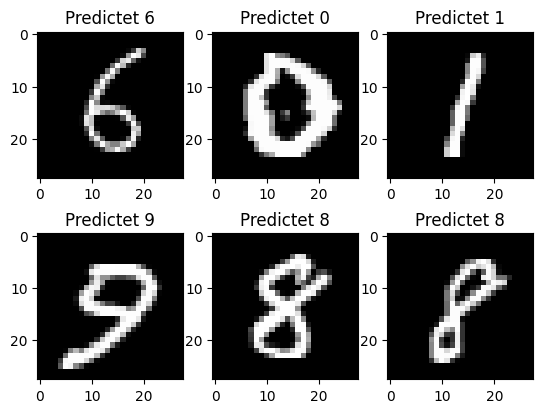

In [27]:
plt.figure()
f, axarr = plt.subplots(2,3)
counter = 0
for i in range(2):
  for j in range(3):
    axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
    axarr[i][j].set_title(f"Predictet {labels[counter]}")
    counter += 1
plt.show()